In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import unicodedata
import re
from sklearn.decomposition import PCA

# Check TensorFlow version
print(f"TensorFlow version: {tf.__version__}")



2025-02-28 01:19:03.869207: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-28 01:19:03.939571: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-28 01:19:04.012048: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740705544.080477      26 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740705544.101616      26 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-28 01:19:04.191170: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

TensorFlow version: 2.18.0


In [2]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Define a small Transformer model for demonstration purposes
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        
        # For attention visualization
        self.attention_scores = None
        
    def call(self, inputs, training=False):
        # Self-attention layer calculates attention between all tokens
        attn_output, attention_scores = self.att(
            inputs, inputs, return_attention_scores=True
        )
        self.attention_scores = attention_scores  # Save for visualization
        
        # First residual connection
        out1 = self.layernorm1(inputs + self.dropout1(attn_output, training=training))
        
        # Feed-forward network
        ffn_output = self.ffn(out1)
        
        # Second residual connection
        out2 = self.layernorm2(out1 + self.dropout2(ffn_output, training=training))
        
        return out2

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
        
    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        token_embeddings = self.token_emb(x)
        return token_embeddings + positions

# Text preprocessing functions
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.strip()
    w = '<start> ' + w + ' <end>'
    return w

def create_dataset(sentence):
    # Process the input sentence
    sentence = preprocess_sentence(sentence)
    
    # Create a small vocabulary from the unique words in the sentence
    words = sentence.split()
    vocab = sorted(set(words))
    
    # Create word-to-index and index-to-word mappings
    word_to_index = {word: i for i, word in enumerate(vocab)}
    index_to_word = {i: word for i, word in enumerate(vocab)}
    
    # Convert sentence to sequence of indices
    sequence = [word_to_index[word] for word in words]
    
    return sequence, word_to_index, index_to_word, vocab, words

# Visualization functions
def plot_attention_weights(attention_weights, words, layer_name=""):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    
    # Plot the attention weights matrix
    cax = ax.matshow(attention_weights, cmap='viridis')
    fig.colorbar(cax)
    
    # Set ticks and labels
    ax.set_xticks(range(len(words)))
    ax.set_yticks(range(len(words)))
    ax.set_xticklabels(words, rotation=45, ha="right")
    ax.set_yticklabels(words)
    
    ax.set_xlabel('Token Position')
    ax.set_ylabel('Attention Position')
    plt.title(f'{layer_name} Attention Weights')
    
    plt.tight_layout()
    return fig

def visualize_token_embeddings(embeddings, words):
    # Use PCA to reduce to 2D for visualization
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)
    
    fig = plt.figure(figsize=(10, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=100)
    
    # Label each point with its word
    for i, word in enumerate(words):
        plt.annotate(word, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]), 
                    xytext=(5, 2), textcoords='offset points')
    
    plt.title("Token Embeddings (PCA 2D projection)")
    plt.grid(True)
    return fig

def demonstrate_transformer(sentence, embed_dim=32, num_heads=2, ff_dim=32):
    """
    Demo function that shows how a sentence is processed through a transformer
    """
    print(f"Input sentence: '{sentence}'")
    
    # Preprocess and create dataset
    sequence, word_to_index, index_to_word, vocab, words = create_dataset(sentence)
    
    # Transformer parameters
    vocab_size = len(vocab)
    maxlen = len(sequence)
    
    print(f"\nVocabulary size: {vocab_size}")
    print(f"Sequence length: {maxlen}")
    print(f"Tokenized sequence: {sequence}")
    print(f"Word mapping: {word_to_index}")
    
    # Convert to tensor
    inputs = tf.convert_to_tensor([sequence])
    
    # Create the Transformer model components
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    
    # Forward pass through embedding layer
    print("\n--- Step 1: Embedding Layer ---")
    print(f"Input tensor shape: {inputs.shape}")
    embedded_inputs = embedding_layer(inputs)
    print(f"After embedding, shape: {embedded_inputs.shape}")
    
    # Visualize token embeddings
    token_embeddings = embedding_layer.token_emb(inputs).numpy()[0]
    print(f"Token embeddings shape: {token_embeddings.shape}")
    
    # Plot and show token embeddings
    token_emb_fig = visualize_token_embeddings(token_embeddings, words)
    plt.show()
    
    # Forward pass through transformer block
    print("\n--- Step 2: Self-Attention ---")
    transformer_output = transformer_block(embedded_inputs)
    print(f"Transformer output shape: {transformer_output.shape}")
    
    # Extract attention weights for visualization
    attention_weights = transformer_block.attention_scores[0, 0].numpy()
    print(f"Attention weights shape: {attention_weights.shape}")
    
    # Visualize attention weights
    print("\n--- Step 3: Attention Visualization ---")
    print("This shows how each word attends to other words in the sequence")
    attn_fig = plot_attention_weights(attention_weights, words, "Self-Attention")
    plt.show()
    
    # Output representation
    print("\n--- Step 4: Final Output Representation ---")
    # Get the output embedding for each token
    output_embeddings = transformer_output[0].numpy()
    print(f"Output embeddings shape: {output_embeddings.shape}")
    
    # Visualize output embeddings
    output_emb_fig = visualize_token_embeddings(output_embeddings, words)
    plt.show()
    
    print("\n--- Transformer Processing Complete ---")
    print("Notice how the attention mechanism allows each word to 'attend' to all other words.")
    print("This is the key innovation of the Transformer - replacing sequential processing with parallel attention.")
    
    return {
        "token_embeddings": token_embeddings,
        "attention_weights": attention_weights,
        "output_embeddings": output_embeddings
    }

Input sentence: 'Attention is all you need for modern deep learning.'

Vocabulary size: 12
Sequence length: 12
Tokenized sequence: [2, 4, 7, 3, 11, 10, 6, 9, 5, 8, 0, 1]
Word mapping: {'.': 0, '<end>': 1, '<start>': 2, 'all': 3, 'attention': 4, 'deep': 5, 'for': 6, 'is': 7, 'learning': 8, 'modern': 9, 'need': 10, 'you': 11}

--- Step 1: Embedding Layer ---
Input tensor shape: (1, 12)
After embedding, shape: (1, 12, 32)
Token embeddings shape: (12, 32)


2025-02-28 01:19:32.673136: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


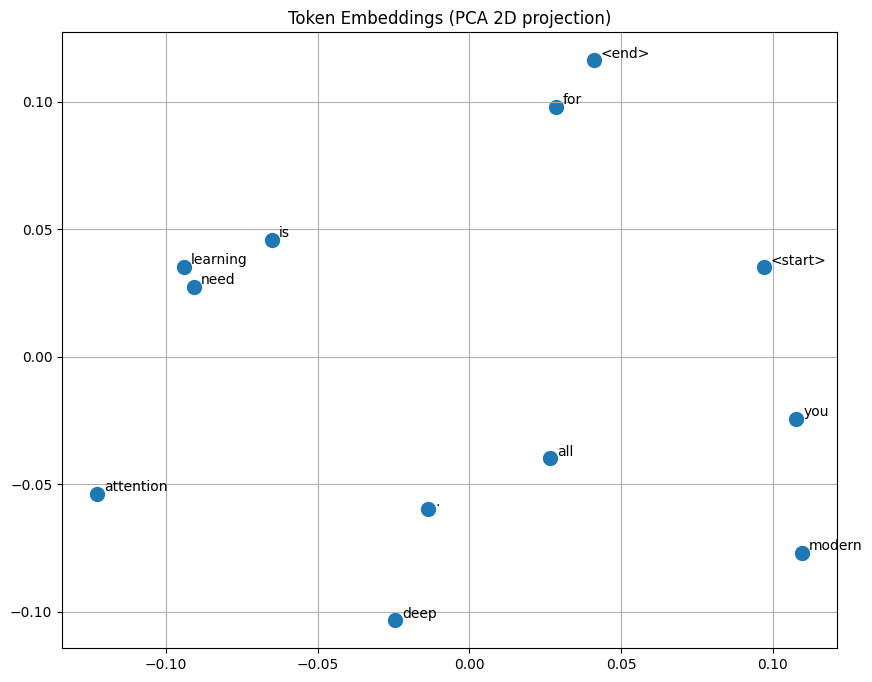


--- Step 2: Self-Attention ---
Transformer output shape: (1, 12, 32)
Attention weights shape: (12, 12)

--- Step 3: Attention Visualization ---
This shows how each word attends to other words in the sequence


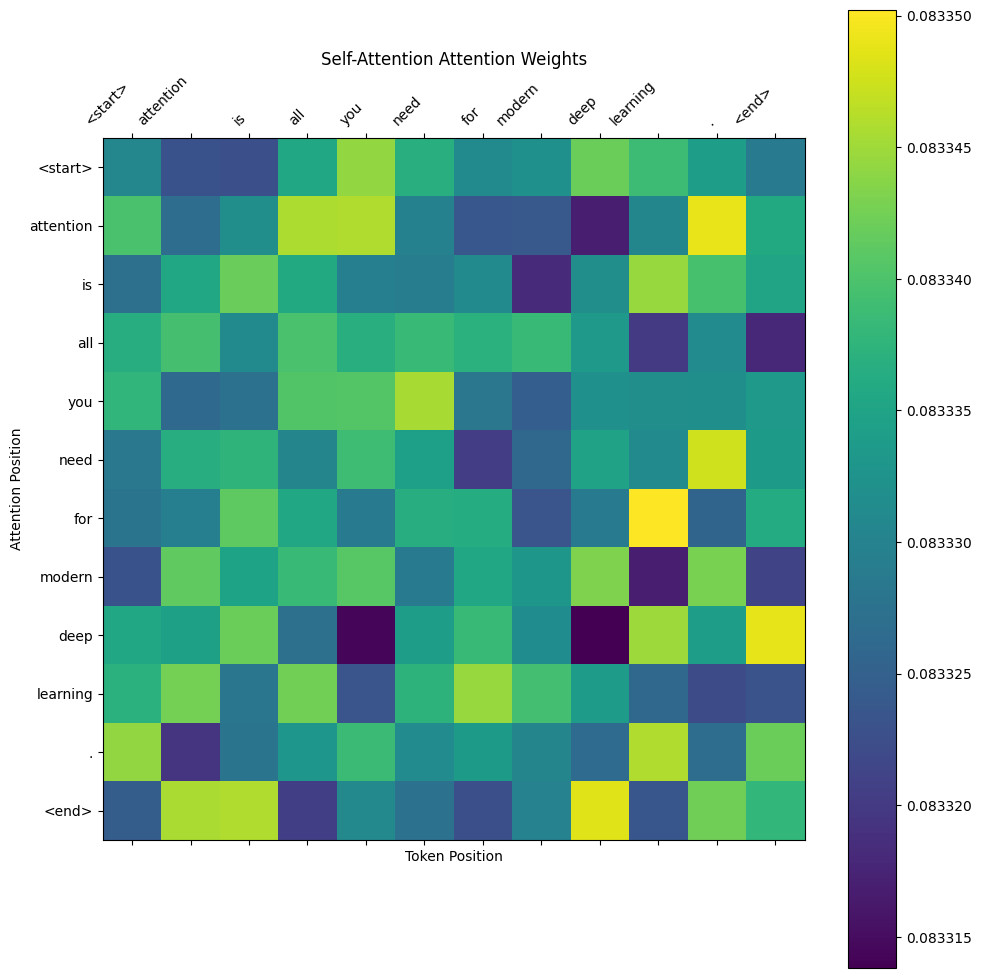


--- Step 4: Final Output Representation ---
Output embeddings shape: (12, 32)


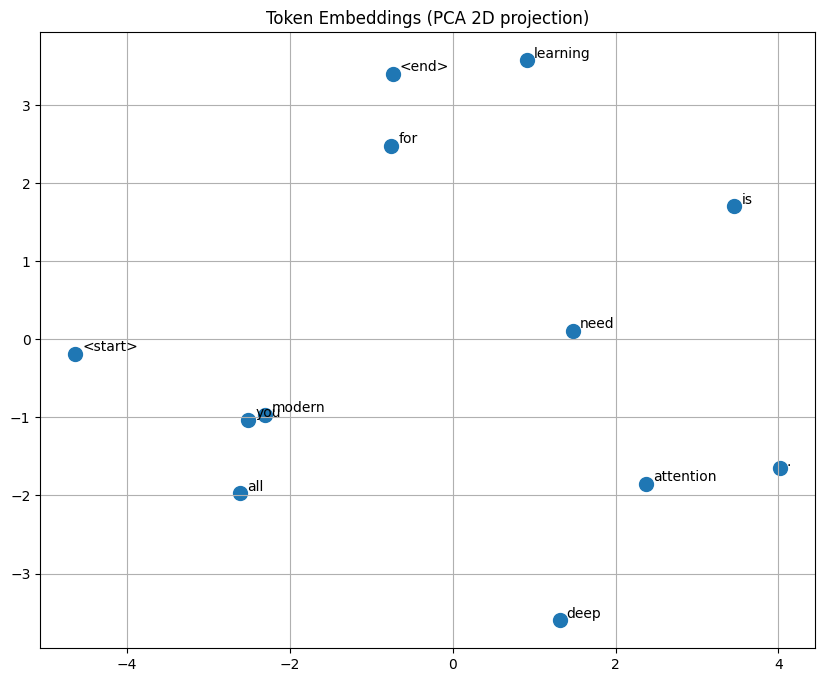


--- Transformer Processing Complete ---
Notice how the attention mechanism allows each word to 'attend' to all other words.
This is the key innovation of the Transformer - replacing sequential processing with parallel attention.


In [3]:
sentence = "Attention is all you need for modern deep learning."
results = demonstrate_transformer(sentence)